In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [24]:
class TransducerLoss(torch.nn.Module):
    def __init__(self):
        super(TransducerLoss, self).__init__()
        
    def show_alignment(self, log_alpha):
        plt.imshow(log_alpha.cpu().data.numpy().transpose()); plt.show()
    
    def compute_log_alpha_and_log_prob(self, encoder_out, decoder_out, y, blank):
        """
        encoder_out: FloatTensor (T, #labels)
        decoder_out: FloatTensor (U, #labels)
        y: LongTensor (U,)
        blank: int
        """
        T = len(encoder_out)
        U = len(y)
        
        log_alphas = []
        log_alpha_t_1 = torch.zeros(U)
        for t in range(T):
            log_alpha_t = [] #torch.zeros(U)
            
            for u in range(U):
                # assume encoder and decoder output a logsoftmax over labels
                y_t_u = encoder_out[t, y[u]] + decoder_out[u, y[u]]
                null_t_u = encoder_out[t, blank] + decoder_out[u, blank]
                if u == 0: log_alpha_t_u_1 = 0
                else: log_alpha_t_u_1 = log_alpha_t[u-1]
                log_alpha_t_1_u = log_alpha_t_1[u]
                
                # if we wanted to use a "joiner" network, we would use these lines instead
                #y_t_u = self.joiner(encoder_out[t, :], decoder_out[u, :])[y[u]]
                #null_t_u = self.joiner(encoder_out[t, :], decoder_out[u, :])[blank]
            
                # log_alpha_t[u] = torch.logsumexp(torch.tensor([
                log_alpha_t_u = torch.logsumexp(torch.tensor([
                    log_alpha_t_1_u + y_t_u,
                    log_alpha_t_u_1 + null_t_u 
                ]), dim=0)
                
                log_alpha_t.append(log_alpha_t_u)
            
            log_alpha_t = torch.tensor(log_alpha_t)
            log_alphas.append(log_alpha_t)
            log_alpha_t_1 = log_alphas[-1]
            print(log_alpha_t_1)
            #log_alpha = torch.stack(log_alphas); self.show_alignment(log_alpha)
            
        log_alpha = torch.stack(log_alphas)
        null_T_U = encoder_out[T-1, blank] + decoder_out[U-1, blank]
        log_p_y_x = log_alpha[T-1,U-1] + null_T_U 
        return log_alpha, log_p_y_x
    
    def forward(self,encoder_out,decoder_out,targets,input_lengths,target_lengths,reduction="none",blank=0):
        """
        encoder_out: FloatTensor (N, max(input_lengths), #labels)
        decoder_out: FloatTensor (N, max(target_lengths), #labels)
        targets: LongTensor (N, max(target_lengths))
        input_lengths: LongTensor (N)
        target_lengths: LongTensor (N)
        reduction: "none", "avg"
        blank: int
        """
        batch_size = len(input_lengths)
        losses = []
        for i in range(0, batch_size):
            encoder_out_ = encoder_out[i, :input_lengths[i], :]
            decoder_out_ = decoder_out[i, :target_lengths[i], :]
            y = targets[i, :target_lengths[i]]
            log_alpha, log_p_y_x = self.compute_log_alpha_and_log_prob(encoder_out_, decoder_out_, y, blank)
            self.show_alignment(log_alpha)
            loss = -log_p_y_x # TODO 
            losses.append(loss)
        losses = torch.stack(losses)
        if reduction=="none": return losses
        if reduction=="avg": return losses.mean()
        

In [22]:
num_labels = 5
blank_index = num_labels-1 # last output = blank
batch_size = 1
pad = -1
T = torch.LongTensor([20])
U = torch.LongTensor([8])
y = torch.randint(low=0,high=num_labels-1,size=(U[0],)).unsqueeze(0).long()
print(y)

encoder_out = torch.randn(batch_size, max(T), num_labels).log_softmax(2).detach().requires_grad_()
decoder_out = torch.randn(batch_size, max(U), num_labels).log_softmax(2).detach().requires_grad_()
print(encoder_out.shape)
print(decoder_out.shape)


tensor([[1, 3, 1, 0, 0, 1, 1, 1]])
torch.Size([1, 20, 5])
torch.Size([1, 8, 5])


In [7]:
# use pre-trained CTC model
from models import CTCModel
from data import read_config
import sentencepiece as spm
import soundfile as sf

config = read_config("experiments/80_mel.cfg")
model = CTCModel(config=config).eval()
model.load_pretrained("experiments/80_mel/training/best_model.pth")
print(model)

tokenizer = spm.SentencePieceProcessor()
tokenizer.Load("tokenizer_1000_tokens.model")

x,fs = sf.read("../end-to-end-SLU/test.wav")
x = torch.tensor(x).unsqueeze(0).float()

guess = model.infer(x)[0]
truth = "HEY COMPUTER COULD YOU TURN THE LIGHTS ON IN THE KITCHEN PLEASE"
print(guess)
print(tokenizer.DecodeIds(guess))
print(tokenizer.EncodeAsIds(truth))
print(truth)

encoder_out = model.encoder.forward(x, T=None).detach().requires_grad_()
print(encoder_out.shape)
num_labels = encoder_out.shape[2]
blank_index = num_labels-1
T = torch.LongTensor([encoder_out.shape[1]])
U = torch.LongTensor([ len(tokenizer.EncodeAsIds(truth)) ]) #torch.LongTensor([ len(guess) ])#
y = torch.LongTensor([ tokenizer.EncodeAsIds(truth) ]) #torch.LongTensor([ guess ]) #
decoder_out = torch.randn(batch_size, max(U), num_labels).log_softmax(2).detach().requires_grad_()
print(decoder_out.shape)
print(y)

CTCModel(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): ComputeFBANK()
      (1): Conv(
        (conv): Conv1d(80, 512, kernel_size=(11,), stride=(2,))
      )
      (2): LeakyReLU(negative_slope=0.125)
      (3): GRU(512, 512, batch_first=True, bidirectional=True)
      (4): RNNOutputSelect()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): LeakyReLU(negative_slope=0.125)
      (8): Downsample()
      (9): GRU(512, 512, batch_first=True, bidirectional=True)
      (10): RNNOutputSelect()
      (11): Dropout(p=0.2, inplace=False)
      (12): Linear(in_features=1024, out_features=512, bias=True)
      (13): LeakyReLU(negative_slope=0.125)
      (14): GRU(512, 512, batch_first=True, bidirectional=True)
      (15): RNNOutputSelect()
      (16): Dropout(p=0.2, inplace=False)
      (17): Linear(in_features=1024, out_features=512, bias=True)
      (18): LeakyReLU(negative_slope=0.125)
      (19): Linear(in_featur

tensor([-2.9554, -3.2427, -2.7443, -4.8041, -3.2075, -2.9009, -2.9757, -1.6584])
tensor([-5.3821, -6.1220, -6.0725, -8.9134, -5.6564, -6.3831, -6.5767, -3.9035])
tensor([ -5.7514,  -9.1779,  -8.4534, -13.8421, -11.3268,  -8.9239,  -9.2291,
         -5.1995])
tensor([ -3.8964,  -6.1104,  -9.7250, -13.2625, -15.8497, -12.5857, -12.8887,
         -7.6169])
tensor([ -5.2493,  -8.2158, -12.7289, -17.4103, -19.5887, -16.5191, -16.9178,
        -10.3055])
tensor([ -6.4031, -10.0844, -14.9984, -21.0889, -23.6496, -19.2034, -19.7208,
        -11.7448])
tensor([ -8.6419, -12.2785, -19.2489, -26.7645, -28.1458, -23.8466, -24.4919,
        -15.1430])
tensor([ -5.2521,  -8.8242, -13.9053, -18.7961, -23.0533, -27.7018, -29.3789,
        -18.7910])
tensor([ -5.0760,  -8.3911, -13.2947, -18.0282, -22.1234, -27.0360, -30.5255,
        -20.9413])
tensor([ -6.5709, -10.3085, -15.5576, -21.8388, -25.8684, -29.6829, -33.1823,
        -22.4040])
tensor([ -5.8585, -10.0304, -15.6868, -21.1870, -25.9639, -31.

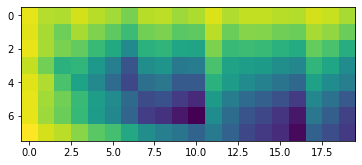

loss: tensor([34.9952], grad_fn=<StackBackward>)
encoder grad:
tensor([[[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.]]])
decoder grad:
tensor([[[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  

In [25]:
transducer_loss = TransducerLoss()
loss = transducer_loss(encoder_out=encoder_out,decoder_out=decoder_out,targets=y,input_lengths=T,target_lengths=U,reduction="none",blank=blank_index)

print("loss:", loss)
loss.mean().backward()

print("encoder grad:")
print(encoder_out.grad)
del encoder_out.grad

print("decoder grad:")
print(decoder_out.grad)
del decoder_out.grad